In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import hdbscan
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


### DATA PREPARATION

In [20]:
# Read in the data
# Main change from v2 to v3 is that the specific regions have been replaced with general regions
cmd_data = pd.read_csv('/data2/home/prasannaiyer/Projects/SKU_Cluster_Local/SKU_Clusters/Data/cmd_attributes_v3_upload.csv',\
    encoding = 'latin-1', decimal = '.', thousands = ',')

In [21]:
cmd_data['p_bu'] = cmd_data['p_bu'].replace({'AW': 'AG', 'CW': 'CE'})

In [22]:
sku_count = cmd_data.shape[0]

In [23]:
attr_input = ['Attr1_Str_qu', 'Attr2_OpPr_qu','Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']

In [24]:
attr_input_cost_model = ['Attr1_Str_qu', 'Attr2_OpPr_qu',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1']
attr_input_subset = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn0', 'Attr9_Frctn1']
attr_input_subset_cost = ['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr9_Frctn0', 'Attr9_Frctn1']

In [25]:
# create an autoencoder class. For init function, input would be the input data, output data, layers. Also in the init function, create the autoencoder model
# For the fit function, input would be the number of epochs, batch size, and the learning rate

class auto_encoder:
    def __init__(self, input_data, output_data, ae_layers, alpha_ae = 0.2):
        self.input_data = input_data
        self.output_data = output_data
        self.ae_layers = ae_layers
        self.alpha_ae = alpha_ae
        self.autoencoder = self.create_autoencoder()
                
    def create_autoencoder(self):
        # create the input layer
        encoder_input = Input(shape=(self.input_data.shape[1],))
        nn_layer = encoder_input
        # create the encoder layers
        for i in range(len(self.ae_layers)):
            layer_name = 'encoder_layer_' + str(i+1)
            layer_name = Dense(self.ae_layers[i])(nn_layer)
            layer_name = LeakyReLU(alpha=self.alpha_ae)(layer_name)
            nn_layer = layer_name
        encoder_output = nn_layer
        self.encoder_model = Model(encoder_input, encoder_output)
        # create the decoder layers
        for i in range(len(self.ae_layers)-2, -1, -1):
            layer_name = 'decoder_layer_' + str(i+1)
            layer_name = Dense(self.ae_layers[i])(nn_layer)
            layer_name = LeakyReLU(alpha=self.alpha_ae)(layer_name)
            nn_layer = layer_name
        decoder_output = nn_layer
        # create the output layer
        autoencoder_output = Dense(self.output_data.shape[1], activation = 'linear')(nn_layer)
        self.ae_model = Model(encoder_input, autoencoder_output)
        # compile the model
        self.ae_model.compile(optimizer='adam', loss='mse')

    # Create a function to fit the model
    def autoencoder_fit(self, epochs = 500, batch_size = 32, verbose = 1):
        self.ae_model_hist = self.ae_model.fit(self.input_data, self.output_data, epochs = epochs, batch_size = batch_size, verbose = verbose)
        self.training_loss = self.ae_model_hist.history['loss'][-1]

    # Create a function to predict the embeddings from the encoder model
    def predict_embeddings(self, input_data):
        self.embeddings = self.encoder_model.predict(input_data)

    # Create a function to plot the training loss
    def plot_training_loss(self):
        plt.figure(figsize = (10, 6))
        ax = sns.lineplot(x = range(1, len(self.ae_model_hist.history['loss']) + 1), y = self.ae_model_hist.history['loss'])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Training Loss')
        ax.set_title('Training Loss vs Epochs')
        ax.grid(linestyle='-', linewidth='0.5', color='red')

    # create a function to print the loss for epochs at specified intervals
    def print_loss(self, interval = 500):
        for i in range(0, len(self.ae_model_hist.history['loss']), interval):
            print(f'Loss at epoch {i}: {self.ae_model_hist.history["loss"][i]:.4f}')
        # print the loss at the last epoch using f-string
        print(f'Loss at epoch {len(self.ae_model_hist.history["loss"])}: {self.ae_model_hist.history["loss"][-1]:.4f}')
        
        # print minimum loss and the epoch at which it occurs
        # print(f'Minimum loss: {min(self.ae_model_hist.history['loss']):.4f} at epoch {self.ae_model_hist.history['loss'].index(min(self.ae_model_hist.history['loss']))}')
        print(f'Minimum loss: {min(self.ae_model_hist.history["loss"]):.4f} at epoch {np.argmin(self.ae_model_hist.history["loss"])}')
    
    


In [26]:
# Function to create clusters of the input data
def create_clusters(input_data, cluster_count = 6):
    # create the k-means model
    kmeans = KMeans(cluster_count, random_state = 42)
    # fit the model
    return kmeans.fit_predict(input_data)        
   


In [31]:
def run_experiments(experiment_details, input_data, cluster_attr, experiment_results):
    # experiment_results = pd.DataFrame(columns = ['Experiment', 'Training Loss', 'Silhouette Score'])
    print(len(experiment_details))
    for experiment in experiment_details:
        print(f'Running experiment: {experiment} with layers: {experiment_details[experiment][0]} and cluster count: {experiment_details[experiment][1]}')
        # create the autoencoder model
        ae = auto_encoder(input_data[cluster_attr], input_data[cluster_attr], experiment_details[experiment][0])
        # fit the model
        ae.autoencoder_fit(epochs = 1000, batch_size = 32, verbose = 0)
        training_loss = ae.training_loss
        # predict the embeddings
        ae.predict_embeddings(input_data[cluster_attr])
        encoded_data = ae.embeddings
        # create the clusters
        label_str = str(experiment) + '_labels'
        input_data[label_str] = create_clusters(encoded_data, cluster_count = experiment_details[experiment][1])
        # calculate the silhouette score
        silh_score_experiment = silhouette_score(input_data[cluster_attr], input_data[label_str])
        # calculate the calinski harabasz score
        cal_harab_score = calinski_harabasz_score(input_data[cluster_attr], input_data[label_str])
        # calculate the davies bouldin score
        dav_bouldin_score = davies_bouldin_score(input_data[cluster_attr], input_data[label_str])
        # Add the experiment results to the dataframe
        # experiment_results.loc[len(experiment_results)] = [experiment, training_loss, silh_score_experiment]
        experiment_results.loc[len(experiment_results)] = [experiment, training_loss, silh_score_experiment, cal_harab_score, dav_bouldin_score]
    return experiment_results, input_data
        

        
        

In [28]:
input_size = len(attr_input)
experiment_details = {'Experiment_2.1':[[input_size*2, 32, 16, 4], 4], \
                      'Experiment_2.2':[[input_size*2, 32, 16, 4], 6], \
                      'Experiment_2.3':[[input_size*2, 32, 16, 4], 8], \
                      'Experiment_3.1':[[input_size*2, 32, 16, 6], 4], \
                      'Experiment_3.2':[[input_size*2, 32, 16, 6], 6], \
                      'Experiment_3.3':[[input_size*2, 32, 16, 6], 8], \
                      'Experiment_4.1':[[input_size*2, 32, 16, 8], 4], \
                      'Experiment_4.2':[[input_size*2, 32, 16, 8], 6], \
                      'Experiment_4.3':[[input_size*2, 32, 16, 8], 8]}
experiment_test = {'Experiment_2.1':[[input_size*2, 32, 16, 4], 4], \
                      'Experiment_2.2':[[input_size*2, 32, 16, 4], 6]}
# experiment_results = pd.DataFrame(columns = ['Experiment', 'Training Loss', 'Silhouette Score'])
experiment_results = pd.DataFrame(columns = ['Experiment', 'Training Loss', 'Silhouette Score', 'Calinski Harabasz Score', 'Davies Bouldin Score'])

In [29]:
# Experiment 1.0 - Compute the results for basic input data
kmeans_plain_cluster_count = [4, 6, 8]
experiment_count = 0
for cluster_count in kmeans_plain_cluster_count:
    experiment_count += 1
    experiment_name = 'Experiment_1.' + str(experiment_count)
    label_str = str(experiment_name) + '_labels'
    cmd_data[label_str] = create_clusters(cmd_data[attr_input_subset], cluster_count)
    silh_score_experiment = silhouette_score(cmd_data[attr_input_subset], cmd_data[label_str])
    cal_harab_score = calinski_harabasz_score(cmd_data[attr_input_subset], cmd_data[label_str])
    dav_bouldin_score = davies_bouldin_score(cmd_data[attr_input_subset], cmd_data[label_str])
    # experiment_results.loc[len(experiment_results)] = [experiment_name, 0, silh_score_experiment]
    experiment_results.loc[len(experiment_results)] = [experiment_name, 0, silh_score_experiment, cal_harab_score, dav_bouldin_score]


In [32]:
#experiment_results, cmd_data_output = run_experiments(experiment_test, cmd_data, attr_input, experiment_results)
experiment_results, cmd_data_output = run_experiments(experiment_details, cmd_data, attr_input_subset, experiment_results)

9
Running experiment: Experiment_2.1 with layers: [28, 32, 16, 4] and cluster count: 4
Running experiment: Experiment_2.2 with layers: [28, 32, 16, 4] and cluster count: 6
Running experiment: Experiment_2.3 with layers: [28, 32, 16, 4] and cluster count: 8
Running experiment: Experiment_3.1 with layers: [28, 32, 16, 6] and cluster count: 4
Running experiment: Experiment_3.2 with layers: [28, 32, 16, 6] and cluster count: 6
Running experiment: Experiment_3.3 with layers: [28, 32, 16, 6] and cluster count: 8
Running experiment: Experiment_4.1 with layers: [28, 32, 16, 8] and cluster count: 4
Running experiment: Experiment_4.2 with layers: [28, 32, 16, 8] and cluster count: 6
Running experiment: Experiment_4.3 with layers: [28, 32, 16, 8] and cluster count: 8


In [33]:
experiment_results

,Experiment,Training Loss,Silhouette Score,Calinski Harabasz Score,Davies Bouldin Score
0,Experiment_1.1,0,0.323156,557.804421,1.065978
1,Experiment_1.2,0,0.359794,544.810123,0.906997
2,Experiment_1.3,0,0.309754,501.340669,1.011917
3,Experiment_2.1,0.000955,0.314822,398.559135,0.975590
4,Experiment_2.2,0.001294,0.241190,402.458943,1.671699
5,Experiment_2.3,0.001385,0.243243,327.100325,1.334369
6,Experiment_3.1,0.000035,0.362728,423.669510,1.043739
7,Experiment_3.2,0.000075,0.228717,354.023757,1.616780
8,Experiment_3.3,0.000055,0.228555,379.980923,1.224933
9,Experiment_4.1,0.000094,0.321816,427.846073,0.973211


In [34]:
cmd_data_output.columns

Index(['Attr1_Str_qu', 'Attr2_OpPr_qu', 'Attr3_Costamount_norm',
       'Attr4_RdDi_norm', 'Attr5_BrDi_norm', 'Attr5_Str_Type1',
       'Attr5_Str_Type2', 'Attr5_Str_Type3', 'Attr6_Major_Type1',
       'Attr6_Major_Type2', 'Attr7_Cshn1', 'Attr7_Cshn2', 'Attr7_Cshn3',
       'Attr7_Cshn4', 'Attr8_Repha1', 'Attr8_Repha2', 'Attr8_Repha3',
       'Attr9_Frctn0', 'Attr9_Frctn1', 'Attr10_Snsr0', 'Attr10_Snsr1',
       'partnumber', 's_nm', 's_country', 's_region', 'p_nm', 'p_bu',
       'p_region', 'Experiment_1.1_labels', 'Experiment_1.2_labels',
       'Experiment_1.3_labels', 'Experiment_2.1_labels',
       'Experiment_2.2_labels', 'Experiment_2.3_labels',
       'Experiment_3.1_labels', 'Experiment_3.2_labels',
       'Experiment_3.3_labels', 'Experiment_4.1_labels',
       'Experiment_4.2_labels', 'Experiment_4.3_labels'],
      dtype='object')

In [38]:
# count by p_bu
sku_count_bu = cmd_data.groupby('p_bu')['p_bu'].count()

In [36]:
# Create a function to plot the cluster details, getting cmd_data, cluster column name as input
def plot_cluster_details(cmd_data, cluster_col_name, sku_count_bu):
    ######## CLUSTER COUNT BY CLUSTER AND CLUSTER COUNT BY p_bu ########
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    # plot the cluster count
    cluster_order = cmd_data[cluster_col_name].value_counts().sort_values(ascending = False).index
    sns.countplot(x = cmd_data[cluster_col_name], ax = ax[0], order = cluster_order)
    ax[0].set_title('Cluster Count')
    ax[0].set_xlabel('Cluster')
    ax[0].set_ylabel('Count')
    ax[0].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    ax[0].bar_label(ax[0].containers[0], labels = \
                    [f'{x} ({y:.2f}%)' \
                     for x, y in zip(ax[0].containers[0].datavalues, \
                                     ax[0].containers[0].datavalues/cmd_data[cluster_col_name].value_counts().sum()*100)])
    # plot the cluster count by p_bu
    p_bu_order = cmd_data.groupby('p_bu')['p_bu'].value_counts().sort_values(ascending = False).index
    hue_order = cluster_order
    sns.countplot(hue = cmd_data[cluster_col_name], x = cmd_data['p_bu'], ax = ax[1])
    # add labels - cluster count & % of total to the bars
    for i in range(len(ax[1].containers)):
        ax[1].bar_label(ax[1].containers[i], labels = \
                        [f'{x} ({y:.2f}%)' \
                         for x, y in zip(ax[1].containers[i].datavalues, \
                                         ax[1].containers[i].datavalues/sku_count_bu.sum()*100)])
    ax[1].set_title('Cluster Count by p_bu')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel('Count')
    ax[1].grid(linestyle='-', linewidth='0.5', color='red')
    ######## PLOT OF CLUSTER COUNT WITH p_bu AND p_region AS HUE #########
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    # plot the cluster count with p_bu as hue
    sns.countplot(hue = cmd_data['p_bu'], x = cmd_data[cluster_col_name], ax = ax[0], order = cluster_order)
    ax[0].set_title('Cluster Count with p_bu as hue')
    ax[0].set_xlabel('Cluster')
    ax[0].set_ylabel('Count')
    ax[0].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    for i in range(len(ax[0].containers)):
        ax[0].bar_label(ax[0].containers[i], labels = \
                        [f'{x} ({y:.2f}%)' \
                         for x, y in zip(ax[0].containers[i].datavalues, \
                                         ax[0].containers[i].datavalues/sku_count_bu.sum()*100)])
    # plot the cluster count with p_region as hue
    sns.countplot(hue = cmd_data['p_region'], x = cmd_data[cluster_col_name], ax = ax[1], order = cluster_order)
    ax[1].set_title('Cluster Count with p_region as hue')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel('Count')
    ax[1].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    for i in range(len(ax[1].containers)):
        ax[1].bar_label(ax[1].containers[i], labels = \
                        [f'{x} ({y:.2f}%)' \
                         for x, y in zip(ax[1].containers[i].datavalues, \
                                         ax[1].containers[i].datavalues/sku_count_bu.sum()*100)])
    
    ######## PLOT OF CLUSTER COUNT FOR p_bu = AG AND p_bu = CE #########
    AG_cluster_order = cmd_data[cmd_data['p_bu'] == 'AG'][cluster_col_name].value_counts().sort_values(ascending = False).index
    CE_cluster_order = cmd_data[cmd_data['p_bu'] == 'CE'][cluster_col_name].value_counts().sort_values(ascending = False).index
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    # plot the cluster count for p_bu = AG
    sns.countplot(x = cmd_data[cmd_data['p_bu'] == 'AG'][cluster_col_name], ax = ax[0], order = AG_cluster_order)
    ax[0].set_title('Cluster Count for p_bu = AG')
    ax[0].set_xlabel('Cluster')
    ax[0].set_ylabel('Count')
    ax[0].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    ax[0].bar_label(ax[0].containers[0], labels = \
                    [f'{x} ({y:.2f}%)' \
                        for x, y in zip(ax[0].containers[0].datavalues, \
                                        ax[0].containers[0].datavalues/sku_count_bu['AG']*100)])
    # plot the cluster count for p_bu = CE
    sns.countplot(x = cmd_data[cmd_data['p_bu'] == 'CE'][cluster_col_name], ax = ax[1], order = CE_cluster_order)
    ax[1].set_title('Cluster Count for p_bu = CE')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel('Count')
    ax[1].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    ax[1].bar_label(ax[1].containers[0], labels = \
                    [f'{x} ({y:.2f}%)' \
                        for x, y in zip(ax[1].containers[0].datavalues, \
                                        ax[1].containers[0].datavalues/sku_count_bu['CE']*100)])   

    ######## PLOT OF CLUSTER COUNT FOR EACH p_bu BY REGION #########
    fig, ax = plt.subplots(1, 2, figsize = (20, 6))
    hue_order = cmd_data[cmd_data['p_bu'] == 'AG'][cluster_col_name].value_counts().sort_values(ascending = False).index
    region_order = cmd_data[cmd_data['p_bu'] == 'AG']['p_region'].value_counts().sort_values(ascending = False).index
    # plot the cluster count for p_bu = AG by region
    sns.countplot(hue = cmd_data[cmd_data['p_bu'] == 'AG'][cluster_col_name], \
        x = cmd_data[cmd_data['p_bu'] == 'AG']['p_region'], ax = ax[0], hue_order = hue_order, order = region_order)
    ax[0].set_title('Cluster Count for p_bu = AG by region')
    ax[0].set_xlabel('Cluster')
    ax[0].set_ylabel('Count')
    ax[0].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    for i in range(len(ax[0].containers)):
        ax[0].bar_label(ax[0].containers[i], labels = \
                        [f'{x} ({y:.2f}%)' \
                            for x, y in zip(ax[0].containers[i].datavalues, \
                                            ax[0].containers[i].datavalues/sku_count_bu['AG']*100)])
    # plot the cluster count for p_bu = CE by region
    hue_order = cmd_data[cmd_data['p_bu'] == 'CE'][cluster_col_name].value_counts().sort_values(ascending = False).index
    region_order = cmd_data[cmd_data['p_bu'] == 'CE']['p_region'].value_counts().sort_values(ascending = False).index
    sns.countplot(hue = cmd_data[cmd_data['p_bu'] == 'CE'][cluster_col_name], \
        x = cmd_data[cmd_data['p_bu'] == 'CE']['p_region'], ax = ax[1], hue_order = hue_order, order = region_order)
    ax[1].set_title('Cluster Count for p_bu = CE by region')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel('Count')
    ax[1].grid(linestyle='-', linewidth='0.5', color='red')
    # add labels - cluster count & % of total to the bars
    for i in range(len(ax[1].containers)):
        ax[1].bar_label(ax[1].containers[i], labels = \
                        [f'{x} ({y:.2f}%)' \
                            for x, y in zip(ax[1].containers[i].datavalues, \
                                            ax[1].containers[i].datavalues/sku_count_bu['CE']*100)])   



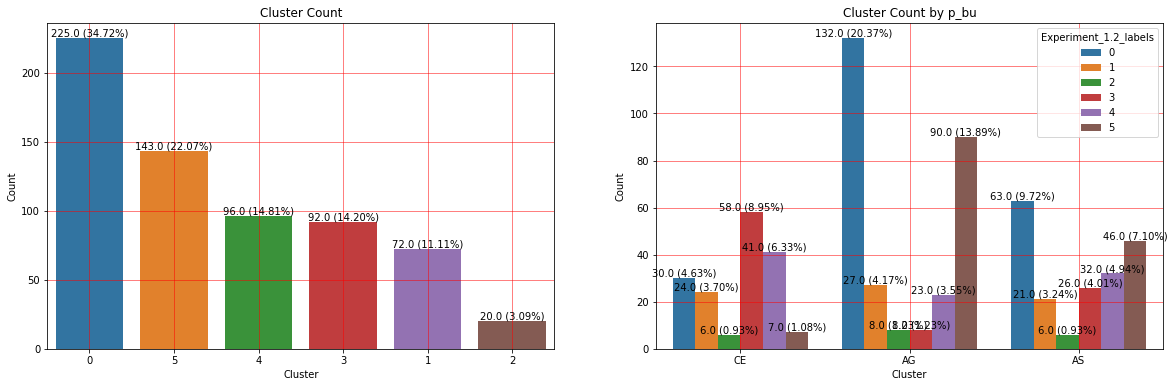

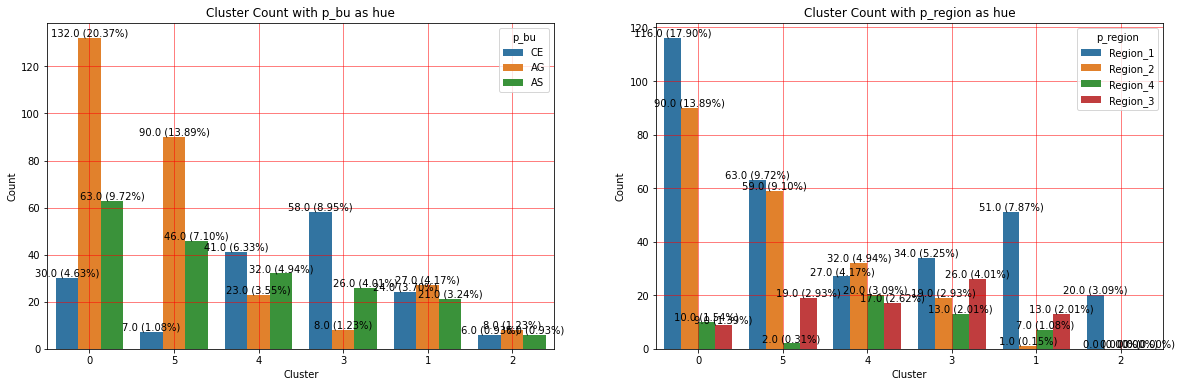

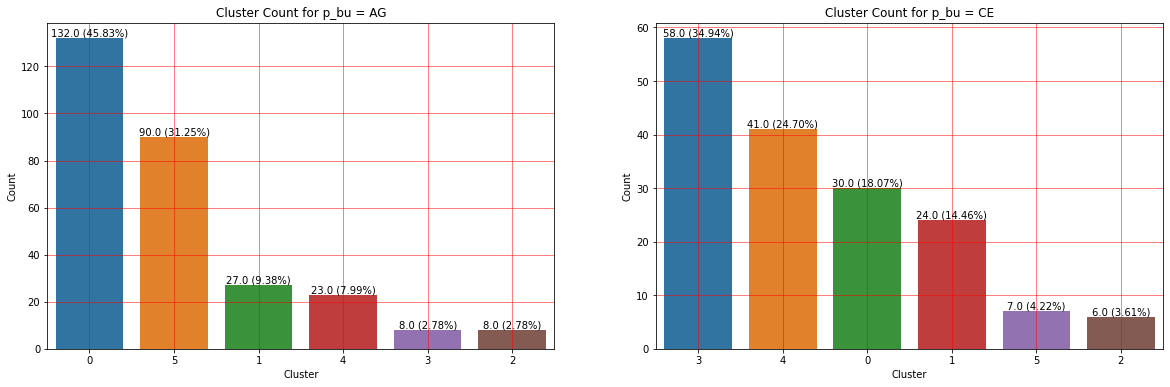

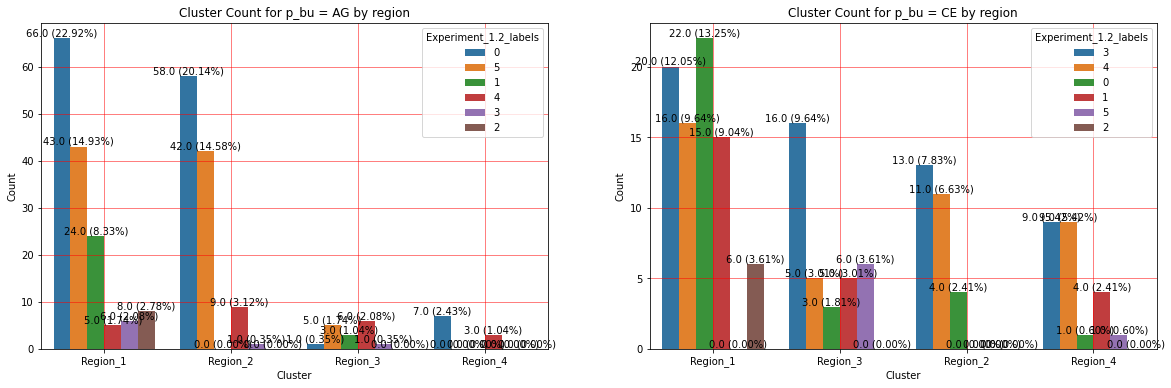

In [39]:
plot_cluster_details(cmd_data, 'Experiment_1.2_labels', sku_count_bu)

In [ ]:
# print the silhouette score for each cluster using mean of silhouette_samples for each cluster
# get the silhouette score for each sample
sample_silhouette_values = silhouette_samples(cmd_data[attr_input], cmd_data['kmeans_labels'])
silh_score_per_cluster = []
for i in range(8):
    silh_score_per_cluster.append(sample_silhouette_values[cmd_data['kmeans_labels'] == i].mean()) 
  
silh_score_per_cluster


In [16]:
input_size = len(attr_input)
ae_layers = [input_size*2, 32, 16, 8]
ae_model = auto_encoder(cmd_data[attr_input], cmd_data[attr_input], ae_layers)

In [17]:
# fit the model
# ae_model_hist = ae_model.ae_model.fit(cmd_data[attr_input], cmd_data[attr_input], epochs = 500, batch_size = 32, verbose = 1)
ae_model.autoencoder_fit(epochs = 500, batch_size = 32, verbose = 1)

Epoch 1/500
21/21 [==============================] - 0s 1ms/step - loss: 0.4602
Epoch 2/500
21/21 [==============================] - 0s 1ms/step - loss: 0.2349
Epoch 3/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1373
Epoch 4/500
21/21 [==============================] - 0s 1ms/step - loss: 0.1016
Epoch 5/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0835
Epoch 6/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0743
Epoch 7/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0685
Epoch 8/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0642
Epoch 9/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0600
Epoch 10/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0565
Epoch 11/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0526
Epoch 12/500
21/21 [==============================] - 0s 1ms/step - loss: 0.0491
Epoch 13/500
21/21 [=================

In [18]:
ae_model.print_loss()

Loss at epoch 0: 0.4602
Loss at epoch 500: 0.0003
Minimum loss: 0.0002 at epoch 486


In [ ]:
input_size = cmd_data[attr_input].shape[1]
l1_size = input_size*2
l2_size = 32
l3_size = 16
bottleneck_size = 8
encoder_input = Input(shape = (input_size, ))
# encoder layer 1
encoder_m5_l1 = Dense(l1_size)(encoder_input)
encoder_m5_l1 = LeakyReLU()(encoder_m5_l1)
# encoder layer 2
encoder_m5_l2 = Dense(l2_size)(encoder_m5_l1)
encoder_m5_l2 = LeakyReLU()(encoder_m5_l2)
# encoder layer 3
encoder_m5_l3 = Dense(l3_size)(encoder_m5_l2)
encoder_m5_l3 = LeakyReLU()(encoder_m5_l3)
# encoder bottleneck layer
encoder_m5_output = Dense(bottleneck_size)(encoder_m5_l3)
encoder_m5_output = LeakyReLU()(encoder_m5_output)
# decoder layer 1
decoder_m5_l1 = Dense(l3_size)(encoder_m5_output)
decoder_m5_l1 = LeakyReLU()(decoder_m5_l1)
# decoder layer 2
decoder_m5_l2 = Dense(l2_size)(decoder_m5_l1)
decoder_m5_l2 = LeakyReLU()(decoder_m5_l2)
# decoder layer 3
decoder_m5_l3 = Dense(l1_size)(decoder_m5_l2)
decoder_m5_l3 = LeakyReLU()(decoder_m5_l3)
# decoder output layer
decoder_m5_output = Dense(input_size, activation = 'linear')(decoder_m5_l3)
# define the autoencoder model
ae_fixed_m5 = Model(encoder_input, decoder_m5_output)

In [ ]:
ae_fixed_m5.summary()

In [ ]:
# compile the model
ae_fixed_m5.compile(optimizer='adam', loss='mse')
# fit the model
ae_fixed_m5_hist = ae_fixed_m5.fit(cmd_data[attr_input], cmd_data[attr_input], epochs = 500, batch_size = 32, verbose = 1)

In [ ]:
# print the loss at epochs 100, 500, 999 and min loss. Format loss to 4 decimal places using f strings
print(f'Loss at epoch 100: {ae_fixed_m5_hist.history["loss"][99]:.4f}')
print(f'Loss at epoch 500: {ae_fixed_m5_hist.history["loss"][499]:.4f}')
#print(f'Loss at epoch 999: {ae_fixed_m5_hist.history["loss"][998]:.4f}')
print(f'Min loss: {min(ae_fixed_m5_hist.history["loss"]):.4f}')
